# 1. Install MarkLLM

In [2]:
# !pip install -r requirements.txt

download_models = False

opt_path = "/workspace/panleyi/models/facebook/opt-1.3b"
llama_path = "/root/model/llama-7b"
nllb_path = "/root/model/nllb-200-distilled-600M"
bert_large_uncased_path = "/root/model/compositional-bert-large-uncased/"
t5_path = "/root/model/t5-v1_1-xxl"
starcoder_path = "/root/model/starcoder"

if download_models:
    !pip install -U huggingface_hub
    !export HF_ENDPOINT=https://hf-mirror.com
    HUGGINGFACE_TOKEN = ""
    !huggingface-cli login --token $HUGGINGFACE_TOKEN
    !huggingface-cli download --resume-download facebook/opt-1.3b --local-dir {opt_path}
    !huggingface-cli download --resume-download princeton-nlp/Sheared-LLaMA-1.3B --local-dir {llama_path}
    !huggingface-cli download --resume-download facebook/nllb-200-distilled-600M --local-dir {nllb_path}
    !huggingface-cli download --resume-download google-bert/bert-large-uncased --local-dir {bert_large_uncased_path}
    !huggingface-cli download --resume-download google/t5-v1_1-xxl --local-dir {t5_path}
    !huggingface-cli download --resume-download bigcode/starcoder --local-dir {starcoder_path}

In [ ]:
import os
import subprocess

# --- 配置区 ---

# 设置为 True 来执行下载，设置为 False 则跳过所有下载
download_models = True

# 定义模型下载的目标路径
opt_path = "/root/model/opt-1.3b"
llama_path = "/root/model/llama-7b"
nllb_path = "/root/model/nllb-200-distilled-600M"
bert_large_uncased_path = "/root/model/compositional-bert-large-uncased"
t5_path = "/root/model/t5-v1_1-xxl"
starcoder_path = "/root/model/starcoder"

gpt2_path = "/root/model/gpt2-large"
SE_path = "/root/model/sentence-transformers"
# https://gitee.com/hf-models/openai-community-gpt2-large

# 将所有模型信息整合到一个列表中，方便循环处理
models_to_download = [
    # ("https://gitee.com/hf-models/opt-1.3b", opt_path),
    # ("https://gitee.com/hf-models/llama-7b", llama_path),
    # ("https://gitee.com/hf-models/nllb-200-distilled-600M", nllb_path),
    ("https://gitee.com/hf-models/compositional-bert-large-uncased", bert_large_uncased_path),
    # ("https://gitee.com/hf-models/t5-v1_1-xxl", t5_path),
    # ("https://gitee.com/hf-models/starcoder", starcoder_path),

#     ("https://gitee.com/hf-models/openai-community-gpt2-large", gpt2_path),
#     ("https://gitee.com/hf-models/all-mpnet-base-v2", SE_path),
]

# --- 执行区 ---

if download_models:
    print("🚀 开始执行模型下载任务...")

    # 步骤 1: 循环下载所有指定的模型
    print("\n[步骤 2/3] 开始克隆模型仓库...")
    for repo_url, local_path in models_to_download:
        model_name = repo_url.split("/")[-1]
        print(f"\n--- 正在处理模型: {model_name} ---")
        
        # 检查目标路径是否已存在
        if os.path.exists(local_path):
            print(f"✔️ 目录 '{local_path}' 已存在，跳过下载。")
            continue
        
        # 创建父目录 (如果不存在)
        parent_dir = os.path.dirname(local_path)
        if parent_dir and not os.path.exists(parent_dir):
            print(f"创建父目录: {parent_dir}")
            os.makedirs(parent_dir, exist_ok=True)
            
        # 构建并执行 git clone 命令
        # 使用 --depth 1 进行浅克隆，大大加快下载速度
        command = f"git clone --depth 1 {repo_url} {local_path}"
        print(f"执行命令: {command}")
        
        try:
            # 使用 os.system 实时显示下载进度
            result_code = os.system(command)
            if result_code == 0:
                print(f"✅ 模型 '{model_name}' 成功下载到 '{local_path}'")
            else:
                print(f"❌ 模型 '{model_name}' 下载失败，返回码: {result_code}")
        except Exception as e:
            print(f"❌ 执行命令时发生异常: {e}")
            
    # 步骤 2: 完成
    print("\n[步骤 3/3] 所有下载任务已处理完毕。")

else:
    print("ℹ️ 'download_models' 设置为 False，已跳过所有下载任务。")

ℹ️ 'download_models' 设置为 False，已跳过所有下载任务。


In [3]:
!mv /home/aistudio/models/gpt2-large /root/model/

# 2. Watermaring Algorithm Invocation

In [2]:
import torch
import json
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load data
with open('dataset/c4/processed_c4.json', 'r') as f:
    lines = f.readlines()
item = json.loads(lines[0])
prompt = item['prompt']
natural_text = item['natural_text']


def test_algorithm(algorithm_name):
    # Check algorithm name
    assert algorithm_name in ['KGW', 'Unigram', 'SWEET', 'EWD', 'SIR', 'XSIR', 'UPV', 'EXP', 'EXPEdit', 'SynthID', 'Adaptive', 'Ambiguity']

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Transformers config
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                                            tokenizer=AutoTokenizer.from_pretrained(opt_path),
                                            vocab_size=50272,
                                            device=device,
                                            max_new_tokens=200,
                                            min_length=230,
                                            do_sample=True,
                                            no_repeat_ngram_size=4)

    # Load watermark algorithm
    myWatermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    # Generate text
    watermarked_text = myWatermark.generate_watermarked_text(prompt)
    unwatermarked_text = myWatermark.generate_unwatermarked_text(prompt)

    # Detect
    detect_result1 = myWatermark.detect_watermark(watermarked_text)
    detect_result2 = myWatermark.detect_watermark(unwatermarked_text)
    detect_result3 = myWatermark.detect_watermark(natural_text)

    print("LLM-generated watermarked text:")
    print(watermarked_text)
    print('\n')
    print(detect_result1)
    print('\n')

    print("LLM-generated unwatermarked text:")
    print(unwatermarked_text)
    print('\n')
    print(detect_result2)
    print('\n')

    print("Natural text:")
    print(natural_text)
    print('\n')
    print(detect_result3)

/root/anaconda3/envs/SHIYI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
test_algorithm('KGW')

LLM-generated watermarked text:
Cluster comprises IBM's Opteron-based eServer 325 server and systems management software and storage devices that can run Linux and Windows operating systems.

IBM’s Opteron server series provides a wide range of performance and scalability advantages over industry industry standard hardware, with the choice of a unified high-speed DDR3 or standard 2.5" SATA drives, as well as one, two or four virtual ports per machine. The company said the server can have up to 75 virtual-to-physical or virtual-to -virtual host conversion capabilities from an existing Oracle database instance, and support up to 15 virtual, physical or mixed physical and virtual instances of Linux.

The firm said the system was designed for large enterprises to support both workloads and large transactions, and it supports more than 60 million lines of data. It handles 5 to 15,000 transactions per second on most workload types, and supports cloud workloads, it said. IBM has described the

In [ ]:
test_algorithm('Unigram')

In [ ]:
test_algorithm('SWEET')

In [ ]:
test_algorithm('UPV')

In [ ]:
test_algorithm('EWD')

In [ ]:
test_algorithm('SIR')

In [ ]:
test_algorithm('XSIR')

In [ ]:
test_algorithm('SynthID')

In [ ]:
test_algorithm('EXP')

In [6]:
test_algorithm('Adaptive')

LLM-generated watermarked text:
. The system also has a 64-bit Intel Xeon CPU with 8 GB memory, a 256 GB SSD storage drive, a 32-bit Intel Atom CPU, a 10 GB SATA hard drive, a 32-bit Intel Atom CPU, a 2 GB Intel Celeron CPU and a 2 GB Intel Celeron CPU.
It's a big step forward for the company, as it will be the first system to run IBM's Open Compute Project. This open-source project aims at providing a common platform on which developers can develop cloud computing services.
The system will be available in the first half of 2013.
IBM has also launched a beta version of its Power Systems software, aimed at helping customers deploy their workloads on the Power System family of products.
The beta version of IBM i Server Manager 6 will be available in the second quarter of 2013.
Copyright 2017 ZDNet.com, Inc. All rights reserved. This material may not be published, broadcast, rewritten or redistributed without prior authorization.


{'is_watermarked': True, 'score': 1.0}


LLM-generated un

In [2]:
import os
print("检查 Adaptive 相关文件:")
print(f"配置文件存在: {os.path.exists('config/Adaptive.json')}")
print(f"模块文件存在: {os.path.exists('watermark/Adaptive.py')}")

# 检查 WATERMARK_MAPPING_NAMES
from watermark.auto_watermark import WATERMARK_MAPPING_NAMES
print(f"'Adaptive' 在映射中: {'Adaptive' in WATERMARK_MAPPING_NAMES}")
print(f"映射值: {WATERMARK_MAPPING_NAMES.get('Adaptive', '未找到')}")

检查 Adaptive 相关文件:
配置文件存在: True
模块文件存在: False
'Adaptive' 在映射中: True
映射值: watermark.adaptive.Adaptive


In [3]:
import os
print("检查 Ambiguity 相关文件:")
print(f"配置文件存在: {os.path.exists('config/Ambiguity.json')}")
print(f"模块文件存在: {os.path.exists('watermark/ambiguity.py')}")

# 检查 WATERMARK_MAPPING_NAMES
from watermark.auto_watermark import WATERMARK_MAPPING_NAMES
print(f"'Ambiguity' 在映射中: {'Ambiguity' in WATERMARK_MAPPING_NAMES}")
print(f"映射值: {WATERMARK_MAPPING_NAMES.get('Ambiguity', '未找到')}")

检查 Ambiguity 相关文件:
配置文件存在: True
模块文件存在: False
'Ambiguity' 在映射中: True
映射值: watermark.ambiguity.Ambiguity


In [3]:
test_algorithm('Ambiguity')

Loaded ambiguity.py


KeyError: 'ambiguity_threshold'

In [1]:
import os
import subprocess

# --- 配置区 ---

# 设置为 True 来执行下载，设置为 False 则跳过所有下载
download_models = False

# 定义模型下载的目标路径
opt_path = "/root/model/opt-1.3b"
llama_path = "/root/model/llama-7b"
nllb_path = "/root/model/nllb-200-distilled-600M"
bert_large_uncased_path = "/root/model/compositional-bert-large-uncased"
t5_path = "/root/model/t5-v1_1-xxl"
starcoder_path = "/root/model/starcoder"

gpt2_path = "/root/model/gpt2-large"
SE_path = "/root/model/sentence-transformers"
# https://gitee.com/hf-models/openai-community-gpt2-large

# 将所有模型信息整合到一个列表中，方便循环处理
models_to_download = [
    # ("https://gitee.com/hf-models/opt-1.3b", opt_path),
    # ("https://gitee.com/hf-models/llama-7b", llama_path),
    # ("https://gitee.com/hf-models/nllb-200-distilled-600M", nllb_path),
    # ("https://gitee.com/hf-models/compositional-bert-large-uncased", bert_large_uncased_path),
    # ("https://gitee.com/hf-models/t5-v1_1-xxl", t5_path),
    # ("https://gitee.com/hf-models/starcoder", starcoder_path),

    ("https://gitee.com/hf-models/openai-community-gpt2-large", gpt2_path),
    ("https://gitee.com/hf-models/all-mpnet-base-v2", SE_path),
]

# --- 执行区 ---

if download_models:
    print("🚀 开始执行模型下载任务...")

    # 步骤 1: 循环下载所有指定的模型
    print("\n[步骤 2/3] 开始克隆模型仓库...")
    for repo_url, local_path in models_to_download:
        model_name = repo_url.split("/")[-1]
        print(f"\n--- 正在处理模型: {model_name} ---")
        
        # 检查目标路径是否已存在
        if os.path.exists(local_path):
            print(f"✔️ 目录 '{local_path}' 已存在，跳过下载。")
            continue
        
        # 创建父目录 (如果不存在)
        parent_dir = os.path.dirname(local_path)
        if parent_dir and not os.path.exists(parent_dir):
            print(f"创建父目录: {parent_dir}")
            os.makedirs(parent_dir, exist_ok=True)
            
        # 构建并执行 git clone 命令
        # 使用 --depth 1 进行浅克隆，大大加快下载速度
        command = f"git clone --depth 1 {repo_url} {local_path}"
        print(f"执行命令: {command}")
        
        try:
            # 使用 os.system 实时显示下载进度
            result_code = os.system(command)
            if result_code == 0:
                print(f"✅ 模型 '{model_name}' 成功下载到 '{local_path}'")
            else:
                print(f"❌ 模型 '{model_name}' 下载失败，返回码: {result_code}")
        except Exception as e:
            print(f"❌ 执行命令时发生异常: {e}")
            
    # 步骤 2: 完成
    print("\n[步骤 3/3] 所有下载任务已处理完毕。")

else:
    print("ℹ️ 'download_models' 设置为 False，已跳过所有下载任务。")


import torch
import json
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load data
with open('dataset/c4/processed_c4.json', 'r') as f:
    lines = f.readlines()
item = json.loads(lines[0])
prompt = item['prompt']
natural_text = item['natural_text']


def test_algorithm(algorithm_name):
    # Check algorithm name
    assert algorithm_name in ['KGW', 'Unigram', 'SWEET', 'EWD', 'SIR', 'XSIR', 'UPV', 'EXP', 'EXPEdit', 'SynthID', 'Adaptive', 'Ambiguity']

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Transformers config
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                                            tokenizer=AutoTokenizer.from_pretrained(opt_path),
                                            vocab_size=50272,
                                            device=device,
                                            max_new_tokens=200,
                                            min_length=230,
                                            do_sample=True,
                                            no_repeat_ngram_size=4)

    # Load watermark algorithm
    myWatermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    # Generate text
    watermarked_text = myWatermark.generate_watermarked_text(prompt)
    unwatermarked_text = myWatermark.generate_unwatermarked_text(prompt)

    # Detect
    detect_result1 = myWatermark.detect_watermark(watermarked_text)
    detect_result2 = myWatermark.detect_watermark(unwatermarked_text)
    detect_result3 = myWatermark.detect_watermark(natural_text)

    print("LLM-generated watermarked text:")
    print(watermarked_text)
    print('\n')
    print(detect_result1)
    print('\n')

    print("LLM-generated unwatermarked text:")
    print(unwatermarked_text)
    print('\n')
    print(detect_result2)
    print('\n')

    print("Natural text:")
    print(natural_text)
    print('\n')
    print(detect_result3)


test_algorithm('Ambiguity')

ℹ️ 'download_models' 设置为 False，已跳过所有下载任务。


/root/anaconda3/envs/SHIYI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded ambiguity.py
LLM-generated watermarked text:
. The system's mainframe-style, multi-tiered storage subsystem includes a variety... [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]> [more ▼]]>

When a major IT firm approached IBM to help the company run its entire IT infrastructure from the cloud, it also wanted an operating system that could work across all of the company’s hardware and software components. That’s exactly what the Opteron-based eServer 325 delivers with its high performance, high reliability, and flexible management, but it requires more than just horsepower to succeed in today’s world. A cluster based on this powerful architecture is built to deliver outstanding support for multiple use cases. It supports two primary workload types: business applications (which are generally used by the largest enterprise customers) and data science.


{'is_watermarked': True, 'score': 1.0}


LLM-generated un

# 3. Mechanism Visualization

In [2]:
import torch
import gc
import json
from visualize.font_settings import FontSettings
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
from visualize.page_layout_settings import PageLayoutSettings
from visualize.data_for_visualization import DataForVisualization
from visualize.visualizer import DiscreteVisualizer, ContinuousVisualizer
from visualize.legend_settings import DiscreteLegendSettings, ContinuousLegendSettings
from visualize.color_scheme import ColorSchemeForDiscreteVisualization, ColorSchemeForContinuousVisualization
from IPython.display import display
from PIL import Image, ImageOps, ImageFont, ImageDraw

def test_discreet_visualization():
    tokens = ["PREFIX", "PREFIX", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test"]
    flags = [-1, -1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]
    weights = [0, 0, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4]

    discreet_visualizer = DiscreteVisualizer(color_scheme=ColorSchemeForDiscreteVisualization(),
                                            font_settings=FontSettings(),
                                            page_layout_settings=PageLayoutSettings(),
                                            legend_settings=DiscreteLegendSettings())
    img = discreet_visualizer.visualize(data=DataForVisualization(tokens, flags, weights),
                                     show_text=True, visualize_weight=True, display_legend=True)

    img.save("test1.png")
    display(img)


def test_continuous_visualization():
    tokens = ["PREFIX", "PREFIX", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test", "Hello", "world", "this", "is", "a", "test"]
    values = [None, None, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4]
    weights = [0, 0, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4, 0.1, 0.5, 0.3, 0.8, 0.2, 0.4]

    continuous_visualizer = ContinuousVisualizer(color_scheme=ColorSchemeForContinuousVisualization(),
                                                    font_settings=FontSettings(),
                                                    page_layout_settings=PageLayoutSettings(),
                                                    legend_settings=ContinuousLegendSettings())
    img = continuous_visualizer.visualize(data=DataForVisualization(tokens, values, weights),
                                        show_text=False, visualize_weight=False, display_legend=True)

    img.save("test2.png")
    display(img)


def get_data(algorithm_name):
    # Load data
    with open('dataset/c4/processed_c4.json', 'r') as f:
        lines = f.readlines()
    item = json.loads(lines[0])
    prompt = item['prompt']

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Transformers config
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                                            tokenizer=AutoTokenizer.from_pretrained(opt_path),
                                            vocab_size=50272,
                                            device=device,
                                            max_new_tokens=200,
                                            min_length=230,
                                            no_repeat_ngram_size=4)

    myWatermark = AutoWatermark.load(f'{algorithm_name}',
                                     algorithm_config=f'config/{algorithm_name}.json',
                                     transformers_config=transformers_config)

    watermarked_text = myWatermark.generate_watermarked_text(prompt)
    unwatermarked_text = myWatermark.generate_unwatermarked_text(prompt)
    watermarked_data = myWatermark.get_data_for_visualization(watermarked_text)
    unwatermarked_data = myWatermark.get_data_for_visualization(unwatermarked_text)

    return watermarked_data, unwatermarked_data


def test_visualization_without_weight(algorithm_name, visualize_type='discrete'):
    # Validate input
    assert visualize_type in ['discrete', 'continuous']
    if visualize_type == 'discrete':
        assert algorithm_name in ['KGW', 'Unigram', 'SWEET', 'UPV', 'SIR', 'XSIR', 'EWD']
    else:
        assert algorithm_name in ['EXP', 'EXPEdit']

    # Get data for visualization
    watermarked_data, unwatermarked_data = get_data(algorithm_name)

    # Init visualizer
    if visualize_type == 'discrete':
        visualizer = DiscreteVisualizer(color_scheme=ColorSchemeForDiscreteVisualization(),
                                        font_settings=FontSettings(),
                                        page_layout_settings=PageLayoutSettings(),
                                        legend_settings=DiscreteLegendSettings())
    else:
        visualizer = ContinuousVisualizer(color_scheme=ColorSchemeForContinuousVisualization(),
                                        font_settings=FontSettings(),
                                        page_layout_settings=PageLayoutSettings(),
                                        legend_settings=ContinuousLegendSettings())

    # Visualize
    watermarked_img = visualizer.visualize(data=watermarked_data,
                                           show_text=True,
                                           visualize_weight=True,
                                           display_legend=True)

    unwatermarked_img = visualizer.visualize(data=unwatermarked_data,
                                             show_text=True,
                                             visualize_weight=True,
                                             display_legend=True)

    watermarked_img.save(f"{algorithm_name}_watermarked.png")
    unwatermarked_img.save(f"{algorithm_name}_unwatermarked.png")

    watermarked_width, watermarked_height = watermarked_img.size
    unwatermarked_width, unwatermarked_height = unwatermarked_img.size

    font_size = 22
    font = ImageFont.truetype("./font/times.ttf", font_size)
    title_height = 80

    new_watermarked_img = Image.new('RGB', (watermarked_width, watermarked_height + title_height), (255, 255, 255))
    new_unwatermarked_img = Image.new('RGB', (unwatermarked_width, watermarked_height + title_height), (255, 255, 255))

    draw1 = ImageDraw.Draw(new_watermarked_img)
    text_bbox1 = draw1.textbbox((0, 0), f"{algorithm_name} watermarked", font=font)
    draw1.text((int((watermarked_width - text_bbox1[2] - text_bbox1[0]) * 0.3), int(title_height * 0.35)), f"{algorithm_name} watermarked", fill=(0, 0, 0), font=font)

    draw2 = ImageDraw.Draw(new_unwatermarked_img)
    text_bbox2 = draw2.textbbox((0, 0), f"{algorithm_name} unwatermarked", font=font)
    draw2.text((int((unwatermarked_width - text_bbox2[2] - text_bbox2[0]) * 0.3), int(title_height * 0.35)), f"{algorithm_name} unwatermarked", fill=(0, 0, 0), font=font)

    new_watermarked_img.paste(watermarked_img, (0, title_height))
    new_unwatermarked_img.paste(unwatermarked_img, (0, title_height))

    total_width = watermarked_width + unwatermarked_width
    max_height = watermarked_height + title_height

    new_img = Image.new('RGB', (total_width, max_height))

    new_img.paste(new_watermarked_img, (0, 0))
    new_img.paste(new_unwatermarked_img, (watermarked_width, 0))
    display(new_img)

def test_visualization_with_weight(algorithm_name):
    # Validate input
    assert algorithm_name in ['SWEET', 'EWD']

    # Get data for visualization
    watermarked_data, unwatermarked_data = get_data(algorithm_name)

    # Init visualizer
    visualizer = DiscreteVisualizer(color_scheme=ColorSchemeForDiscreteVisualization(),
                                    font_settings=FontSettings(),
                                    page_layout_settings=PageLayoutSettings(),
                                    legend_settings=DiscreteLegendSettings())

    # Visualize
    watermarked_img = visualizer.visualize(data=watermarked_data,
                                           show_text=True,
                                           visualize_weight=True,
                                           display_legend=True)

    unwatermarked_img = visualizer.visualize(data=unwatermarked_data,
                                             show_text=True,
                                             visualize_weight=True,
                                             display_legend=True)

    watermarked_img.save(f"{algorithm_name}_watermarked.png")
    unwatermarked_img.save(f"{algorithm_name}_unwatermarked.png")

    watermarked_width, watermarked_height = watermarked_img.size
    unwatermarked_width, unwatermarked_height = unwatermarked_img.size

    font_size = 22
    font = ImageFont.truetype("./font/times.ttf", font_size)
    title_height = 80

    new_watermarked_img = Image.new('RGB', (watermarked_width, watermarked_height + title_height), (255, 255, 255))
    new_unwatermarked_img = Image.new('RGB', (unwatermarked_width, watermarked_height + title_height), (255, 255, 255))

    draw1 = ImageDraw.Draw(new_watermarked_img)
    text_bbox1 = draw1.textbbox((0, 0), f"{algorithm_name} watermarked", font=font)
    draw1.text((int((watermarked_width - text_bbox1[2] - text_bbox1[0]) * 0.3), int(title_height * 0.35)), f"{algorithm_name} watermarked", fill=(0, 0, 0), font=font)

    draw2 = ImageDraw.Draw(new_unwatermarked_img)
    text_bbox2 = draw2.textbbox((0, 0), f"{algorithm_name} unwatermarked", font=font)
    draw2.text((int((unwatermarked_width - text_bbox2[2] - text_bbox2[0]) * 0.3), int(title_height * 0.35)), f"{algorithm_name} unwatermarked", fill=(0, 0, 0), font=font)

    new_watermarked_img.paste(watermarked_img, (0, title_height))
    new_unwatermarked_img.paste(unwatermarked_img, (0, title_height))

    total_width = watermarked_width + unwatermarked_width
    max_height = watermarked_height + title_height

    new_img = Image.new('RGB', (total_width, max_height))

    new_img.paste(new_watermarked_img, (0, 0))
    new_img.paste(new_unwatermarked_img, (watermarked_width, 0))
    display(new_img)

## 3.1 Warm Up: Test Visualizer Using Provided Text

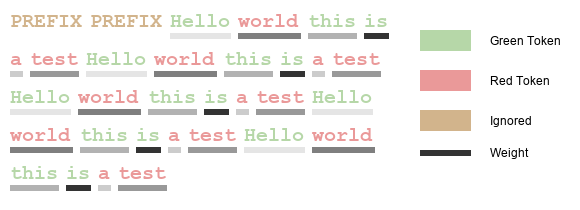

In [3]:
test_discreet_visualization()

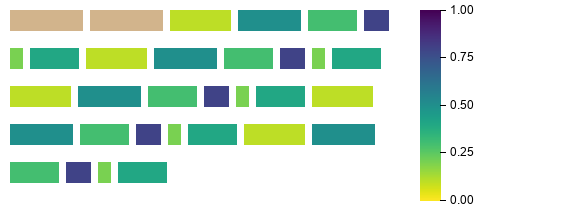

In [4]:
test_continuous_visualization()

## 3.2 Mechansim Visualization of Watermarking Algorithms

### 3.2.1 KGW Family

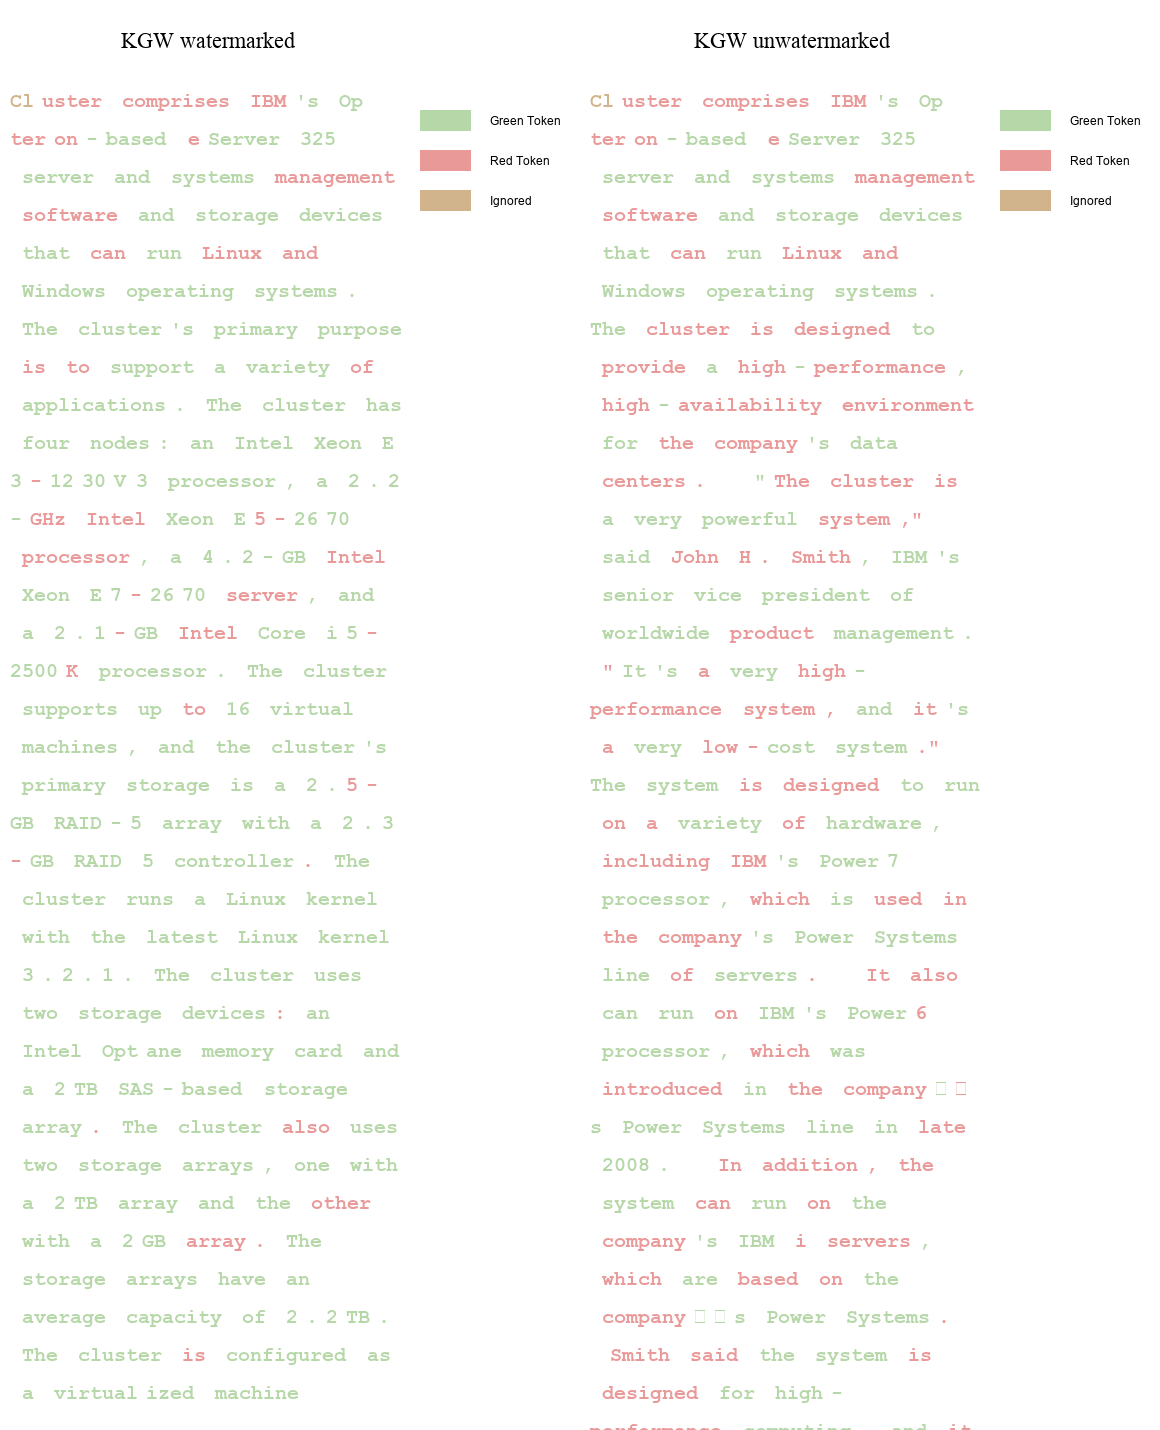

In [5]:
test_visualization_without_weight('KGW', 'discrete')

### 3.2.2 Christ Family

In [ ]:
test_visualization_without_weight('EXP', 'continuous')

### 3.2.3 Handling Weighted Token Difference in Visualization

In [ ]:
test_visualization_with_weight('SWEET')

In [ ]:
test_visualization_with_weight('EWD')

# 4. Automated Comprehensive Evaluation

## 4.1 Watermark Detection Pipeline

In [6]:
import torch
import json
from evaluation.dataset import C4Dataset
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from evaluation.tools.success_rate_calculator import DynamicThresholdSuccessRateCalculator
from transformers import AutoModelForCausalLM, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration, BertTokenizer, BertForMaskedLM
from evaluation.pipelines.detection import WatermarkedTextDetectionPipeline, UnWatermarkedTextDetectionPipeline, DetectionPipelineReturnType
from evaluation.tools.text_editor import TruncatePromptTextEditor, TruncateTaskTextEditor, WordDeletion, SynonymSubstitution, ContextAwareSynonymSubstitution, GPTParaphraser, DipperParaphraser

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
  gc.collect()
  torch.cuda.empty_cache()
  with torch.no_grad():
      torch.cuda.empty_cache()

def test_detection_pipeline(algorithm_name, attack_name):
    my_dataset = C4Dataset('dataset/c4/processed_c4.json')
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                                             tokenizer=AutoTokenizer.from_pretrained(opt_path),
                                             vocab_size=50272,
                                             device=device,
                                             max_new_tokens=200,
                                             min_length=230,
                                             do_sample=True,
                                             no_repeat_ngram_size=4)

    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    if attack_name == 'Word-D':
      attack = WordDeletion(ratio=0.3)
    elif attack_name == 'Word-S':
      attack = SynonymSubstitution(ratio=0.5)
    elif attack_name == 'Word-S(Context)':
      attack = ContextAwareSynonymSubstitution(ratio=0.5,
                                               tokenizer=BertTokenizer.from_pretrained('/data2/shared_model/bert-large-uncased'),
                                               model=BertForMaskedLM.from_pretrained('/data2/shared_model/bert-large-uncased').to(device))
    elif attack_name == 'Doc-P(GPT-3.5)':
        attack = GPTParaphraser(openai_model='gpt-3.5-turbo',
                                prompt='Please rewrite the following text: ')
    elif attack_name == 'Doc-P(Dipper)':
        attack = DipperParaphraser(tokenizer=T5Tokenizer.from_pretrained('/data2/shared_model/google/t5-v1_1-xxl/'),
                                   model=T5ForConditionalGeneration.from_pretrained('/data2/shared_model/kalpeshk2011/dipper-paraphraser-xxl/', device_map='auto'),
                                   lex_diversity=60, order_diversity=0, sent_interval=1,
                                   max_new_tokens=100, do_sample=True, top_p=0.75, top_k=None)


    pipline1 = WatermarkedTextDetectionPipeline(dataset=my_dataset, text_editor_list=[TruncatePromptTextEditor(), attack],
                                                show_progress=True, return_type=DetectionPipelineReturnType.SCORES)

    pipline2 = UnWatermarkedTextDetectionPipeline(dataset=my_dataset, text_editor_list=[TruncatePromptTextEditor()],
                                            show_progress=True, return_type=DetectionPipelineReturnType.SCORES)

    calculator = DynamicThresholdSuccessRateCalculator(labels=['TPR', 'F1'], rule='best')
    print(calculator.calculate(pipline1.evaluate(my_watermark), pipline2.evaluate(my_watermark)))



In [7]:
test_detection_pipeline('KGW', 'Word-D')

Processing: 100%|██████████| 200/200 [00:05<00:00, 33.37it/s]

{'TPR': 1.0, 'F1': 0.9950248756218906}


## 4.2 Text Quality Analysis Pipeline

In [23]:
import torch
import json
from watermark.auto_watermark import AutoWatermark
from utils.transformers_config import TransformersConfig
from evaluation.dataset import C4Dataset, WMT16DE_ENDataset, HumanEvalDataset
from evaluation.tools.success_rate_calculator import DynamicThresholdSuccessRateCalculator
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM, AutoTokenizer, LlamaTokenizer
from evaluation.tools.text_editor import TruncatePromptTextEditor, TruncateTaskTextEditor ,CodeGenerationTextEditor
from evaluation.tools.text_quality_analyzer import PPLCalculator, LogDiversityAnalyzer, BLEUCalculator, PassOrNotJudger, GPTTextDiscriminator
from evaluation.pipelines.detection import WatermarkedTextDetectionPipeline, UnWatermarkedTextDetectionPipeline, DetectionPipelineReturnType
from evaluation.pipelines.quality_analysis import (DirectTextQualityAnalysisPipeline, ReferencedTextQualityAnalysisPipeline, ExternalDiscriminatorTextQualityAnalysisPipeline,
                                                   QualityPipelineReturnType)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
  gc.collect()
  torch.cuda.empty_cache()
  with torch.no_grad():
      torch.cuda.empty_cache()

def test_direct_quality_analysis_pipeline(algorithm_name, quality_analyzer_name):
    my_dataset = C4Dataset('dataset/c4/processed_c4.json')
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(opt_path).to(device),
                          tokenizer=AutoTokenizer.from_pretrained(opt_path),
                          vocab_size=50272,
                          device=device,
                          max_new_tokens=200,
                          min_length=230,
                          do_sample=True,
                          no_repeat_ngram_size=4)
    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    if quality_analyzer_name == 'PPL':
      analyzer = PPLCalculator(model=AutoModelForCausalLM.from_pretrained(llama_path, device_map='auto'),
                                tokenizer=LlamaTokenizer.from_pretrained(llama_path),
                                device=device)
    elif quality_analyzer_name == 'Log Diversity':
      analyzer = LogDiversityAnalyzer()

    analyzers = []
    analyzers.append(analyzer)

    quality_pipeline = DirectTextQualityAnalysisPipeline(dataset=my_dataset,
                                watermarked_text_editor_list=[TruncatePromptTextEditor()],
                                unwatermarked_text_editor_list=[],
                                analyzers=analyzers,
                                unwatermarked_text_source='natural', show_progress=True,
                                return_type=QualityPipelineReturnType.MEAN_SCORES)

    print(f"{quality_analyzer_name}:")
    print(quality_pipeline.evaluate(my_watermark))


def test_referenced_quality_analysis_pipeline_1(algorithm_name):
    """Evaluate the impact on text quality in the machine translation task."""
    my_dataset = WMT16DE_ENDataset('dataset/wmt16_de_en/validation.jsonl')
    tokenizer= AutoTokenizer.from_pretrained(nllb_path, src_lang="deu_Latn")
    transformers_config = TransformersConfig(model=AutoModelForSeq2SeqLM.from_pretrained(nllb_path).to(device),
                                                tokenizer=tokenizer,
                                                device=device,
                                                forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"])

    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    quality_pipeline = ReferencedTextQualityAnalysisPipeline(dataset=my_dataset,
                                                              watermarked_text_editor_list=[],
                                                              unwatermarked_text_editor_list=[],
                                                              analyzer=BLEUCalculator(),
                                                              unwatermarked_text_source='generated', show_progress=True,
                                                              return_type=QualityPipelineReturnType.MEAN_SCORES)


    print("BLEU:")
    print(quality_pipeline.evaluate(my_watermark))


def test_referenced_quality_analysis_pipeline_2(algorithm_name):
    """Evaluate the impact on text quality in the code generation task."""
    my_dataset = HumanEvalDataset('dataset/human_eval/test.jsonl')
    tokenizer= AutoTokenizer.from_pretrained(tiny_starcoder_path)
    transformers_config = TransformersConfig(model=AutoModelForCausalLM.from_pretrained(tiny_starcoder_path, device_map='auto'),
                                             tokenizer=tokenizer,
                                             device=device,
                                             min_length=200,
                                             max_length=400)

    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    quality_pipeline = ReferencedTextQualityAnalysisPipeline(dataset=my_dataset,
                                  watermarked_text_editor_list=[TruncateTaskTextEditor(),CodeGenerationTextEditor()],
                                  unwatermarked_text_editor_list=[TruncateTaskTextEditor(), CodeGenerationTextEditor()],
                                  analyzer=PassOrNotJudger(),
                                  unwatermarked_text_source='generated', show_progress=True,
                                  return_type=QualityPipelineReturnType.MEAN_SCORES)

    print("pass@1:")
    print(quality_pipeline.evaluate(my_watermark))


def test_discriminator_quality_analysis_pipeline(algorithm_name):
    my_dataset = WMT16DE_ENDataset('dataset/wmt16_de_en/validation.jsonl')
    tokenizer= AutoTokenizer.from_pretrained(nllb_path, src_lang="deu_Latn")
    transformers_config = TransformersConfig(model=AutoModelForSeq2SeqLM.from_pretrained(nllb_path).to(device),
                                                tokenizer=tokenizer,
                                                device=device,
                                                forced_bos_token_id=tokenizer.lang_code_to_id["eng_Latn"])

    my_watermark = AutoWatermark.load(f'{algorithm_name}', algorithm_config=f'config/{algorithm_name}.json', transformers_config=transformers_config)

    quality_pipeline = ExternalDiscriminatorTextQualityAnalysisPipeline(dataset=my_dataset,
                                      watermarked_text_editor_list=[],
                                      unwatermarked_text_editor_list=[],
                                      analyzer=GPTTextDiscriminator(openai_model='gpt-4',
                                      task_description='Translate the following German text to English'),
                                      unwatermarked_text_source='generated', show_progress=True,
                                      return_type=QualityPipelineReturnType.MEAN_SCORES
                                      )

    print("Win Rate:")
    print(quality_pipeline.evaluate(my_watermark))

In [ ]:
test_direct_quality_analysis_pipeline('KGW', 'PPL')

In [ ]:
test_direct_quality_analysis_pipeline('Unigram', 'Log Diversity')

In [ ]:
test_referenced_quality_analysis_pipeline_1('SIR')

In [ ]:
test_referenced_quality_analysis_pipeline_2('SWEET')

In [ ]:
import openai

openai.api_key = ""

test_discriminator_quality_analysis_pipeline('EWD')